In [82]:
from numba import jit, njit

import numpy as np
import scipy
import math
from numpy.linalg import inv #routine to invert matrix
import matplotlib.pyplot as plt
from qutip import *
import time
import sys
from scipy.interpolate import interp1d
from scipy.special import factorial

import kwant

from matplotlib.colors import LinearSegmentedColormap


import Lattices as ltt
import DispersionHopping as dh

In [83]:

def effVdis(Nx, Ny, R, dr, xic, xi0):
    Vdis = np.zeros(shape=(Nx*Ny, Nx*Ny), dtype=np.complex_)
    Vxy = np.zeros(shape=(Nx, Ny), dtype=np.complex_)


    #Vxy = np.power(1.5, 3.)*(2*np.random.rand(Nx, Ny) - 1.)
    Vxy = np.random.normal(0, 1., size=(Nx, Ny))/(dr)

    kVxy = np.fft.fft2(Vxy)
    kx = np.zeros(shape=(Nx, 1), dtype=np.complex_)
    ky = np.zeros(shape=(1, Ny), dtype=np.complex_)
    ix = np.zeros(shape=(1, Nx), dtype=np.complex_)
    iy = np.zeros(shape=(Ny, 1), dtype=np.complex_)
    kx[:,0] = 2*np.pi * np.fft.fftfreq(kVxy.shape[0],d=dr)
    ky[0,:] = 2*np.pi * np.fft.fftfreq(kVxy.shape[1],d=dr)
    ix[0,:] =  np.ones(Nx)
    iy[:,0] =  np.ones(Ny)
    k2 = np.matmul(np.square(kx), ix) + np.matmul(iy, np.square(ky))

    norm = np.sqrt(2.)/xic
    kVxy = xi0 * np.multiply(kVxy, np.exp( - .125*xic*xic*k2 ) )/norm
    #norm = np.sqrt(np.sum(np.square(Vxy))/(1.*Nx*Ny))

    #norm = 2./xic*np.sqrt(np.sqrt(np.pi/4.))
    Vxy = np.fft.ifft2(kVxy)
    Vxy = Vxy - np.sum(Vxy)/(1.*Nx*Ny)

    Vdis = np.diag( Vxy.flatten('F') )

    """
    idx = kx[:,0].argsort()[::-1]
    idx = np.flip(idx)
    idy = ky[0, :].argsort()[::-1]
    idy = np.flip(idy)
    kx = kx[idx,:]
    ky = ky[:, idy]
    kVxy = kVxy[:,idy]
    kVxy = kVxy[idx,:]
    p_kVdis = open("data/kvdis.dat", "w")
    p_Vdis = open("data/vdis.dat", "w")
    n = 0
    for ny in range(Ny):
        for nx in range(Nx):
            p_kVdis.write("%f %f %f\n" % (kx[nx][0].real, ky[0][ny].real, np.abs(kVxy[nx][ny]) ))
            p_Vdis.write("%f %f %f\n" % (R[0][n]*dr, R[1][n]*dr, Vxy[nx][ny].real ))
            p_kVdis.flush()
            p_Vdis.flush()
            n += 1
        p_Vdis.write("\n")
        p_Vdis.flush()
        p_kVdis.write("\n")
        p_kVdis.flush()
    """

    return Vdis

def corr_dis(L, W, a, xic):
    Nx = int(L/a)
    Ny = int(W/a)
    Vxy = np.random.normal(0, 1., size=(Ny, Nx))/(a) + 1j*0.0
    
    kkVxy = np.fft.fft2(Vxy)
    kx = 2*np.pi * np.fft.fftfreq(kkVxy.shape[1],d=a)
    ky = 2*np.pi * np.fft.fftfreq(kkVxy.shape[0],d=a)
    kx, ky = np.meshgrid(kx,ky)
    
    kVxy = np.multiply(kkVxy, np.exp( - .125 * (xic)**2. * (kx**2.+ky**2.)  ) ) * (xic)/np.sqrt(2.)
    #kVxy = np.divide(kkVxy, np.sqrt( (kx**2.+ky**2.) + (1/xic)**2./4.  ) )*np.sqrt(1./xic/(2*np.pi))
    
    #xlong = W/4.
    #xavg = (xic + xlong)/2.
    #kVxy = np.multiply(kkVxy, np.exp( - .125**3. * xic**4. * (kx**4.+ky**4.)  ) ) * (xavg/2.)/np.sqrt(2.)
    #kVxy += np.multiply(kkVxy, np.exp( - .125 * (xlong)**2. * (kx**2.+ky**2.)  ) ) * (xavg/2.)/np.sqrt(2.)
    
    Vxy = np.fft.ifft2(kVxy)
    Vxy = Vxy - np.sum(Vxy)/(1.*Nx*Ny)
    
    Vdis = np.diag( Vxy.flatten('F') )

    return Vdis

In [84]:
Nx = 230
Ny = 50

In [85]:

R, M = ltt.square_lattice( Nx, Ny, 1 )

BW = 20 #in meV
l0 = np.sqrt(568/BW*8.) * 10**(-3.) # sqrt( \hbar^2/(2m*)/(\hbar J)) here I took \hbar^2/(2m*) = 568 nm^2 meV (GaAs) and \hbar J = BW/8 in micron!
B0 = 4.14*10**3. / (l0 * 10**3.)**2. #in T, as 2\pi \hbar/e 1/a^2


J = 1.
alpha = 1./40.
lB = 1./np.sqrt(2*np.pi*alpha)
omB = 4*np.pi*alpha*J
omega_0 = 4*J
dis = .3/BW*8
xic = 2

omega_ = dh.disp_flat_emitters(omega_0, M, 0)
omegaE = dh.ph_electric_field(.0003, M, R) * 0
#omegaDis = effVdis(Nx, Ny, R, 1, xic, dis)
omegaDis = corr_dis(Nx, Ny, 1, xic)
omegaDis = omegaDis*dis
#V = dh.hopping_matrix_HH( J, R, M, alpha )
V = dh.PBC_hopping_matrix_HH( J, R, M, Nx, Ny, alpha, 0 )
#V = dh.inhomo_hopping_matrix_HH( J, R, M, alpha_vec )

H = np.diag(omega_*0+omegaE) + V + omegaDis

evals, evecs = np.linalg.eig(H)
idx = np.argsort(evals)
evals = evals[idx]
evecs = evecs[:,idx]
EGS = evals[0]
evals = evals - evals[0]


In [86]:
print(omB, lB, Nx*Ny/lB**2./(2*np.pi))
print(alpha*B0, l0, xic*l0*1000, lB*l0*1000)

0.3141592653589793 2.5231325220201604 287.49999999999994
0.4555457746478873 0.015073154945133418 30.146309890266835 38.03156745151513


In [87]:
XXX = np.matmul( np.conj(evecs.T), np.matmul(np.diag(R[:,0]), evecs) )

#YYY = np.matmul( np.conj(evecs.T), np.matmul(np.diag((R[:,0]-Nx/2.)**2.), evecs) )


In [88]:
vecX = np.abs(np.diagonal(XXX))

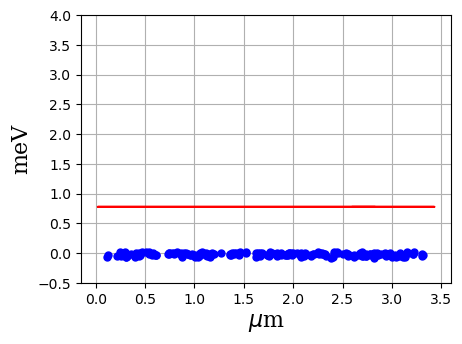

In [89]:
# Parameters
LL = 1
omB_corr = 4 * np.pi * alpha * J * LL - (4 * np.pi * alpha * J) ** 2 / (32. * J) * (2 * LL ** 2. + 2. * LL + 1.)
omB_corr_dis = omB_corr + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2

# Define the font style
font = {'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 16,
        }

# Create the plot
plt.figure(figsize=(120 / 25.4, 90 / 25.4))  # This sets the figure size to be approximately the same as the previous plots

# Plotting
Nev = 200
plt.plot(np.abs(np.diagonal(XXX)[:Nev]) * l0, (evals[:Nev].real + EGS + 4 - omB_corr_dis/2.) * BW / 8., linestyle='none', marker='o', color='blue', ms=5)
plt.plot(np.abs(np.diagonal(XXX)) * l0, np.ones(np.abs(np.diagonal(XXX)).size) * (omB_corr_dis) * BW / 8., color='red')

# Axis limits
plt.ylim((-.5, 4))

# Axis labels
plt.xlabel(r'$\mu$m', fontdict=font)
plt.ylabel(r'meV', fontdict=font)

# Grid
plt.grid()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

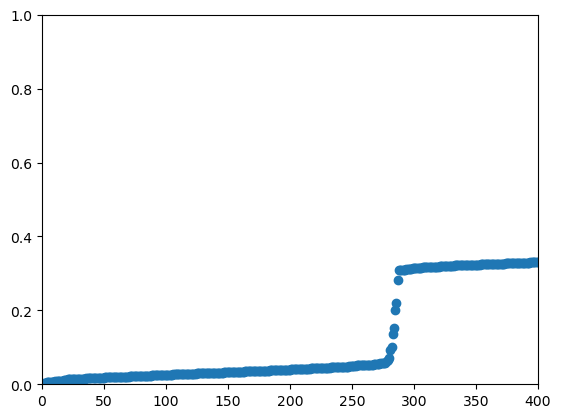

In [90]:
plt.plot(np.linspace(0,evals.size-1, evals.size), evals.real, linestyle='none', marker='o')
plt.xlim((0,400))
plt.ylim((0,1.))
plt.show()

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_24008/3597379069.py:17: RuntimeWarning: divide by zero encountered in log
  Y.append(np.log(arr_VV / lB) / np.log(10.))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.9364255756146647


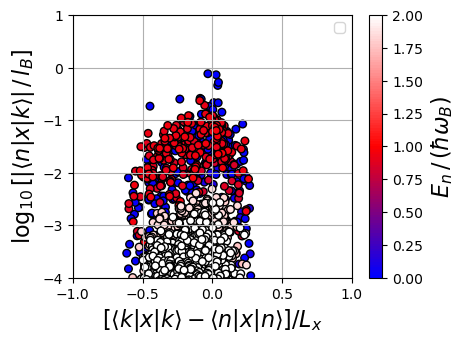

In [91]:
N = 1
n0 = 250
X = []
Y = []
Z = []

for ni in range(n0, N+n0):
    arr_VV = []
    for n in range(evals.size):
        if n != ni:
            arr_VV.append(np.abs(XXX[n][ni]))
        else:
            arr_VV.append(0)
    arr_VV = np.asarray(arr_VV)
    
    X.append((vecX - vecX[ni]) / Nx)
    Y.append(np.log(arr_VV / lB) / np.log(10.))
    Z.append(np.abs(evals - evals[ni]) / omB)
    print(np.amax(arr_VV))

# Create a custom colormap from blue to red to white
colors = [(0, 0, 1), (1, 0, 0), (1, 1, 1)]  # Blue -> Red -> White
n_bins = 100  # Number of color bins
cmap_name = 'blue_red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Create the figure with the desired size
fig, ax = plt.subplots(figsize=(120 / 25.4, 90 / 25.4))

vmin = 0
vmax = 2

# Plot each set of X, Y, Z
for i in range(N):
    XN = (X[i])
    YN = (Y[i])
    ZN = (Z[i])
    sc = ax.scatter(XN, YN, c=ZN, cmap=cm, edgecolor='k', vmin=vmin, vmax=vmax, s=30)

# Set limits, labels, and title with the desired font style
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16}

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label(r'$E_n\, / \, (\hbar \omega_B)$', fontdict=font)

ax.set_ylim((-4, 1))
ax.set_xlim((-1., 1.))
ax.set_xlabel(r'$\left[ \langle{k|x|k\rangle} - \langle{n|x|n\rangle}\right]/L_x$', fontdict=font)
ax.set_ylabel(r'$\log_{10}\left[ |\langle{n|x|k\rangle}|\,/\,l_B \right]$', fontdict=font)
#ax.set_title('Matrix element X', fontdict=font)

# Add grid and legend
ax.grid(True)
ax.legend()

# Adjust layout and save the figure
plt.tight_layout()
#plt.savefig('Xnk_vs_X_Lx_n%d_Nx%d_Ny%d_BW%.2f_alpha%.2f_dis%.2f_xic%.2f.svg' % (n0, Nx, Ny, BW, alpha, dis, xic))
#plt.savefig('Xnk_vs_X_Lx_n%d_Nx%d_Ny%d_BW%.2f_alpha%.2f_dis%.2f_xic%.2f.pdf' % (n0, Nx, Ny, BW, alpha, dis, xic))
# Show plot
plt.show()

In [92]:
n0 = 2

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_24008/3164657483.py:20: RuntimeWarning: divide by zero encountered in log
  Y.append(np.log(arr_VV / lB) / np.log(10.))


3.0860112998834803


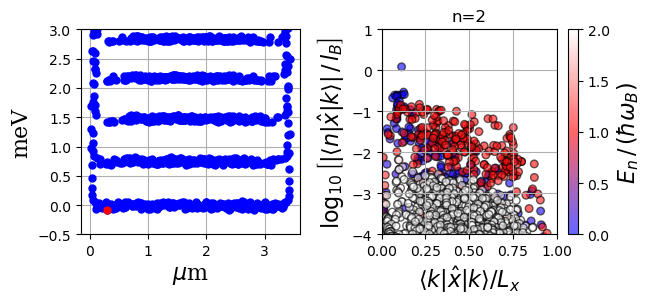

In [93]:

LL = 1
omB_corr = 4 * np.pi * alpha * J * LL - (4 * np.pi * alpha * J) ** 2 / (32. * J) * (2 * LL ** 2. + 2. * LL + 1.)
omB_corr_dis = omB_corr + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2

N = 1
X = []
Y = []
Z = []

for ni in range(n0, N + n0):
    arr_VV = []
    for n in range(evals.size):
        if n != ni:
            arr_VV.append(np.abs(XXX[n][ni]))
        else:
            arr_VV.append(0)
    arr_VV = np.asarray(arr_VV)
    
    X.append((vecX - 0*vecX[ni]) / Nx)
    Y.append(np.log(arr_VV / lB) / np.log(10.))
    Z.append(np.abs(evals - evals[ni]) / omB)
    print(np.amax(arr_VV))

# Create a custom colormap from blue to red to white
colors = [(0, 0, 1), (1, 0, 0), (1, 1, 1)]  # Blue -> Red -> White
n_bins = 100  # Number of color bins
cmap_name = 'blue_red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(170 / 25.4, 80 / 25.4))  # 240 mm by 90 mm figure

# Plot 1
ax1.plot(np.abs(np.diagonal(XXX)) * l0, ( evals.real + EGS + 4 - omB_corr_dis / 2. ) * BW / 8., linestyle='none', marker='o', color='blue', ms=5)
#ax1.plot(np.abs(np.diagonal(XXX)) * l0, np.ones(np.abs(np.diagonal(XXX)).size) * (omB_corr_dis) * BW / 8., color='red')
ax1.plot(np.abs(XXX[n0][n0]) * l0, ( evals[n0].real + EGS + 4 - omB_corr_dis / 2. ) * BW / 8., linestyle='none', marker='o', color='red', ms=5)

# Axis limits, labels, and grid for Plot 1
ax1.set_ylim((-.5, 3))
ax1.set_xlabel(r'$\mu$m', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16})
ax1.set_ylabel(r'meV', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16})
ax1.grid(True)

# Plot 2
from matplotlib.colors import Normalize

for i in range(N):
    XN = (X[i])
    YN = (Y[i])
    ZN = (Z[i])
    
    """norm = Normalize(vmin=0, vmax=1)
    cmap_vals = cm(norm(ZN))  # shape (N, 4), includes RGBA
    alphas = 1.0 - 0.8 * norm(ZN)  # alpha decreases as ZN increases
    # Replace the alpha (4th channel) in colormap with custom alpha values
    colors_with_alpha = cmap_vals.copy()
    colors_with_alpha[:, -1] = alphas  # set alpha channel
    # Now plot with pre-computed RGBA colors
    sc = ax2.scatter(XN, YN, color=colors_with_alpha, edgecolor='k', s=30)"""


    #sc = ax2.scatter(XN, YN, c=ZN, cmap=cm, edgecolor='k', vmin=0, vmax=2, s=30, alpha=None)
    #sc.set_alpha(None)  # Ensure individual alpha per point is used
    #sc.set_facecolors([(r, g, b, a) for (r, g, b, _), a in zip(cm(norm(ZN)), alphas)])
    sc = ax2.scatter(XN, YN, c=ZN, cmap=cm, edgecolor='k', vmin=0, vmax=2, s=30, alpha=0.6)

# Add colorbar for Plot 2
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label(r'$E_n\, / \, (\hbar \omega_B)$', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16})

# Axis limits, labels, and grid for Plot 2
ax2.set_ylim((-4, 1))
ax2.set_xlim((-0., 1.))
ax2.set_xlabel(r'$\langle{k|\hat{x}|k\rangle}/L_x$', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16})
ax2.set_ylabel(r'$\log_{10}\left[ |\langle{n|\hat{x}|k\rangle}|\,/\,l_B \right]$', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16})
ax2.grid(True)

# Adjust layout and display the figure
ax2.set_title('n=%d'%(n0))
plt.tight_layout()
#plt.savefig('Xnk_vs_X_Lx_n%d_Nx%d_Ny%d_BW%.2f_alpha%.2f_dis%.2f_xic%.2f.svg' % (n0, Nx, Ny, BW, alpha, dis, xic))
#plt.savefig('Xnk_vs_X_Lx_n%d_Nx%d_Ny%d_BW%.2f_alpha%.2f_dis%.2f_xic%.2f.pdf' % (n0, Nx, Ny, BW, alpha, dis, xic))
plt.show()

In [94]:
#x2_vec = np.diagonal(YYY)

In [95]:
#plt.plot(evals/omB, x2_vec, marker='o', linestyle='none')
#plt.xlim(0,.3)


In [96]:
omB_corr_dis = omB_corr + dis * xic / lB / np.sqrt(2 * np.pi * (2 + (xic / lB) ** 2.)) / 2

x_elms = XXX/lB - Nx/lB/2.*np.diag(np.ones(len(evals)))
#np.fill_diagonal(x_elms, 0)

E = ( evals  - evals[0] )/ omB
M = E[:, np.newaxis] - E
M = M.T
#M[np.abs(M) <= 0.75] = 0.0

omc = 1.

@njit
def heff(E, M, x, omc):
    Nh = np.argmin(np.abs(E-.85))
    h = np.zeros( shape=(Nh,Nh), dtype=np.complex_ )
    for n in range(Nh):
        for m in range(Nh):
            if n==m:
                    h[n][m] += .25 / omc #A^2 term in Coulomb
            for k in range(int(len(E)/2)):
                
                
                #h[n][m] += x[n][k]*x[k][m] * M[n][k] /(M[n][k] + omc +0j)/2 + x[n][k]*x[k][m] * M[m][k] /(M[m][k] + omc + 0j)/2 
                
                h[n][m] +=  - x[n][k]*x[k][m] * M[k][n]*M[k][m] /(M[n][k] + omc +0j)/2 - x[n][k]*x[k][m] * M[k][m]*M[k][n] /(M[m][k] + omc + 0j)/2 #2nd order term in Coulomb
                
                #h[n][m] += x[n][k]*x[k][m] /( omc +0j) * omc
                #h[n][m] += - x[n][k]*x[k][m] /(M[n][k] + omc +0j)/2 * omc - x[n][k]*x[k][m]  /(M[m][k] + omc + 0j)/2 * omc
                
                #if k != n and k != m :
                #    h[n][m] += x[n][k]*x[k][m] /( omc +0j) * omc
                #    h[n][m] += - x[n][k]*x[k][m] /(M[n][k] + omc +0j)/2 * omc - x[n][k]*x[k][m]  /(M[m][k] + omc + 0j)/2 * omc
        
    return 2*(h.T + h)/2., np.diag(E[:Nh])

Heff, H0 = heff(E, M, x_elms, omc)

In [97]:
a = .2

evalseff, eveceff = np.linalg.eig(  a *Heff + H0)

x_eff = np.zeros(len(evalseff))

for n in range(len(evalseff)):
    x_eff[n] = np.matmul(np.conj(eveceff[:,n].T), np.matmul(x_elms[:len(evalseff),:len(evalseff)], eveceff[:,n]))


/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_24008/3772951147.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  x_eff[n] = np.matmul(np.conj(eveceff[:,n].T), np.matmul(x_elms[:len(evalseff),:len(evalseff)], eveceff[:,n]))


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


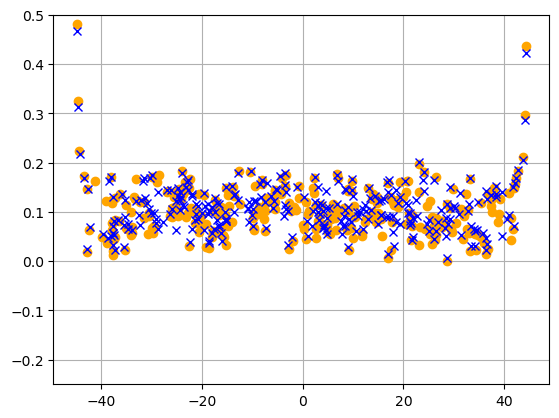

In [98]:
Nev1 = 800
plt.plot(np.diagonal(x_elms)[:Nev1], (evals[:Nev1].real-evals[0].real)/omB, linestyle='none', marker='o', color='orange')
plt.plot(x_eff, evalseff, linestyle='none', marker='x', color='blue')

x_arr = np.linspace(np.amin(x_eff), np.amax(x_eff), 30)
#plt.plot(x_arr, 1./(1+omc)*np.ones(len(x_arr)), color='black')
cent_er = ( .25*dis/omB + .03*0 )
#plt.plot(x_arr, a/(1+omc)*np.ones(len(x_arr)) + cent_er, color='red' )

#plt.plot(x_arr, a/(1+omc)*np.ones(len(x_arr)) + .25*dis/omB +   a*2*(dis/omB)* (lB/Nx)**2 *(x_arr-0*np.amax(x_arr)/2)**2 + cent_er, color='blue' )
#plt.plot(x_arr, a/(1+omc)*np.ones(len(x_arr)) - .25*dis/omB -   a*2*(dis/omB)* (lB/Nx)**2 *(x_arr-0*np.amax(x_arr)/2)**2 + cent_er, color='blue' )


plt.ylim(-.25,.5)
plt.grid()


In [99]:
print(np.amax(R[:,0]), Nx, lB)

229.0 230 2.5231325220201604


In [100]:
#Kn = np.sum(np.square(np.abs(Heff - np.eye(len(Heff))*.25 / omc)), axis=0 )
Kn = np.zeros( Heff.shape[0] )
for n in range(Heff.shape[0]):
    for m in range(Heff.shape[0]):
        if n!= m:
            Kn[n] += np.square(np.abs( Heff[m][n]))

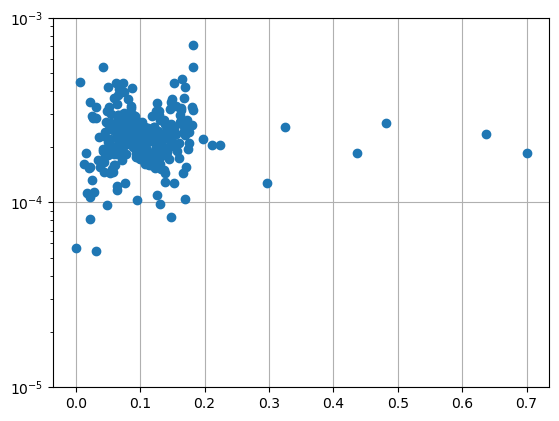

In [101]:
plt.plot( (evals[0:len(Kn)] )/ omB, Kn, marker='o', linestyle='none')
plt.yscale('log')
plt.ylim(1e-5, 1e-3)
plt.grid()

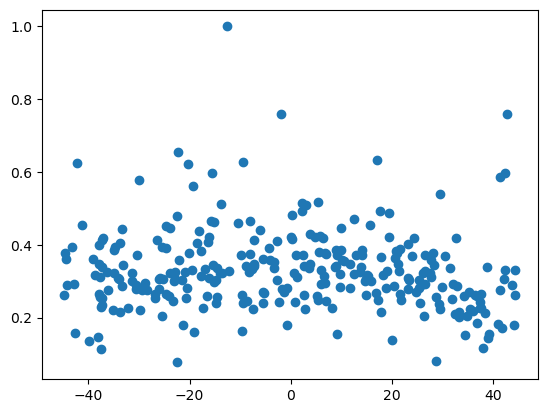

In [102]:
plt.plot( np.diagonal(x_elms)[:len(Kn)], Kn/np.amax(Kn), marker='o', linestyle='none')
